In [3]:
import gym

env = gym.make("BipedalWalker-v3")

env.action_space


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Box(-1.0, 1.0, (4,), float32)

In [1]:
import lbforaging

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/envs/registration.py:423: UserWarning: WARN: Custom namespace `ALE` is being overridden by namespace `ALE`. If you are developing a plugin you shouldn't specify a namespace in `register` calls. The namespace is specified through the entry point package metadata.
  logger.warn(


In [1]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, batch_size=32, size=1000000):
        '''
        batch_size (int): number of data points per batch
        size (int): size of replay buffer.
        '''
        self.batch_size = batch_size
        self.memory = deque(maxlen=size)

    def remember(self, s_t, a_t, r_t, s_t_next, d_t):
        '''
        s_t (np.ndarray double): state
        a_t (np.ndarray int): action
        r_t (np.ndarray double): reward
        d_t (np.ndarray float): done flag
        s_t_next (np.ndarray double): next state
        '''
        self.memory.append((s_t, a_t, r_t, s_t_next, d_t))

    def sample(self):
        '''
        random sampling of data from buffer
        '''
        # if we don't have enough samples yet
        size = min(self.batch_size, len(self.memory))
        return random.sample(self.memory, size)

In [4]:
import copy

class VectorizedEnvWrapper(gym.Wrapper):
    def __init__(self, env, num_envs=1):
        '''
        env (gym.Env): to make copies of
        num_envs (int): number of copies
        '''
        super().__init__(env)
        self.num_envs = num_envs
        self.envs = [copy.deepcopy(env) for n in range(num_envs)]

    def reset(self):
        '''
        Return and reset each environment
        '''
        return np.asarray([env.reset() for env in self.envs])

    def step(self, actions):
        '''
        Take a step in the environment and return the result.
        actions (np.ndarray int)
        '''
        next_states, rewards, dones = [], [], []
        for env, action in zip(self.envs, actions):
            next_state, reward, done, _ = env.step(action)
            if done:
                next_states.append(env.reset())
            else:
                next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)
        return np.asarray(next_states), np.asarray(rewards), \
            np.asarray(dones)

In [5]:
import torch
import numpy as np

In [6]:
class DeepQLearner:
    def __init__(self, env,
                 alpha=0.001, gamma=0.95,
                 epsilon_i=1.0, epsilon_f=0.00, n_epsilon=0.1):
        '''
        env (VectorizedEnvWrapper): the vectorized gym.Env
        alpha (float): learning rate
        gamma (float): discount factor
        epsilon_i (float): initial value for epsilon
        epsilon_f (float): final value for epsilon
        n_epsilon (float): proportion of timesteps over which to
                           decay epsilon from epsilon_i to
                           epsilon_f
        '''

        self.num_envs = env.num_envs
        self.M = env.action_space.n  # number of actions
        self.N = env.observation_space.shape[0] # dimensionality of state space

        self.epsilon_i = epsilon_i
        self.epsilon_f = epsilon_f
        self.n_epsilon = n_epsilon
        self.epsilon = epsilon_i
        self.gamma = gamma

        self.Q = torch.nn.Sequential(
            torch.nn.Linear(self.N, 24),
            torch.nn.ReLU(),
            torch.nn.Linear(24, 24),
            torch.nn.ReLU(),
            torch.nn.Linear(24, self.M)
        ).double()

        self.Q_ = copy.deepcopy(self.Q)

        self.optimizer = torch.optim.Adam(self.Q.parameters(), lr=alpha)

    def synchronize(self):
        '''
        Used to make the parameters of Q_ match with Q.
        '''
        self.Q_.load_state_dict(self.Q.state_dict())

    def act(self, s_t):
        '''
        Epsilon-greedy policy.
        s_t (np.ndarray): the current state.
        '''
        s_t = torch.as_tensor(s_t).double()
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.M, size=self.num_envs)
        else:
            with torch.no_grad():
                return np.argmax(self.Q(s_t).numpy(), axis=1)

    def decay_epsilon(self, n):
        '''
        Epsilon decay.
        n (int): proportion of training complete
        '''
        self.epsilon = max(
            self.epsilon_f,
            self.epsilon_i - (n/self.n_epsilon)*(self.epsilon_i - self.epsilon_f))

    def update(self, s_t, a_t, r_t, s_t_next, d_t):
        '''
        Learning step.
        s_t (np.ndarray double): state
        a_t (np.ndarray int): action
        r_t (np.ndarray double): reward
        d_t (np.ndarray float): done flag
        s_t_next (np.ndarray double): next state
        '''

        # make sure everything is torch.Tensor and type-compatible with Q
        s_t = torch.as_tensor(s_t).double()
        a_t = torch.as_tensor(a_t).long()
        r_t = torch.as_tensor(r_t).double()
        s_t_next = torch.as_tensor(s_t_next).double()
        d_t = torch.as_tensor(d_t).double()

        # we don't want gradients when calculating the target y
        with torch.no_grad():
            # taking 0th element because torch.max returns both maximum
            # and argmax
            Q_next = torch.max(self.Q_(s_t_next), dim=1)[0]
            target = r_t + (1-d_t)*self.gamma*Q_next

        # use advanced indexing on the return to get the predicted
        # Q values corresponding to the actions chosen in each environment.
        Q_pred = self.Q(s_t)[range(self.num_envs), a_t]
        loss = torch.mean((target - Q_pred)**2)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [7]:
def train(env, agent, replay_buffer, T=20000, n_theta=100):
    '''
    env (VectorizedEnvWrapper): vectorized gym.Env
    agent (DeepQLearner)
    buffer (ReplayBuffer)
    T (int): total number of training timesteps
    batch_size: number of
    '''

    # for plotting
    returns = []
    episode_rewards = 0

    s_t = env.reset()
    for t in range(T):
        # synchronize Q and Q_
        if t%n_theta == 0:
            agent.synchronize()

        a_t = agent.act(s_t)
        s_t_next, r_t, d_t = env.step(a_t)

        # store data into replay buffer
        replay_buffer.remember(s_t, a_t, r_t, s_t_next, d_t)
        s_t = s_t_next

        # learn by sampling from replay buffer
        for batch in replay_buffer.sample():
            agent.update(*batch)

        # for plotting
        episode_rewards += r_t
        for i in range(env.num_envs):
            if d_t[i]:
                returns.append(episode_rewards[i])
                episode_rewards[i] = 0

        # epsilon decay
        agent.decay_epsilon(t/T)

    plot_returns(returns)
    return agent

In [8]:
import pandas as pd
import seaborn as sns; sns.set()

In [9]:
def plot_returns(returns, window=10):
    '''
    Returns (iterable): list of returns over time
    window: window for rolling mean to smooth plotted curve
    '''
    sns.lineplot(
        data=pd.DataFrame(returns).rolling(window=window).mean()[window-1::window]
    )

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


CPU times: user 55 s, sys: 1.95 s, total: 57 s
Wall time: 1min 16s


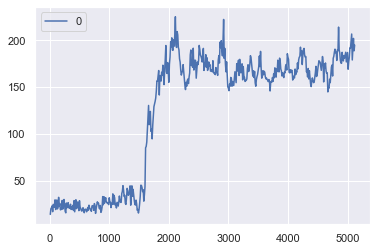

In [10]:
%%time

env = VectorizedEnvWrapper(gym.make("CartPole-v1"), num_envs=32)
agent = DeepQLearner(env, alpha=1e-3, gamma=0.95)
replay_buffer = ReplayBuffer(batch_size=1)
agent = train(env, agent, replay_buffer, T=20000)

In [11]:
def test(env, agent, T=20000):
    '''
    env (VectorizedEnvWrapper): vectorized gym.Env
    agent (DeepQLearner)
    buffer (ReplayBuffer)
    T (int): total number of training timesteps
    batch_size: number of
    '''

    # for plotting
    returns = []
    episode_rewards = 0

    s_t = env.reset()
    env.render()
    for t in range(T):
        a_t = agent.act(s_t)
        s_t_next, r_t, d_t = env.step(a_t)
        env.render()

        episode_rewards += r_t

In [12]:
test(env,agent)